# Online learning

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

logs_2018 = pd.read_csv('logs/logs_2018.csv', index_col='datetime', parse_dates=True)

hackers_2018 = pd.read_csv(
    'logs/hackers_2018.csv', 
    converters={'start' : np.datetime64, 'end': np.datetime64}
).assign(
    duration=lambda x: x.end - x.start, 
    start_floor=lambda x: x.start.dt.floor('min'),
    end_ceil=lambda x: x.end.dt.ceil('min')
)

In [2]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A pandas DataFrame
    """
    return pd.get_dummies(log[day].assign(
        failures=lambda x: np.invert(x.success)
    ).query('failures').resample('1min').agg(
        {'username':'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username':'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        A pandas Series of booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series()
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

def get_X_y(log, day, hackers):
    """
    Get the X, y data to build a model with.
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
        - hackers: The dataframe indicating when the attacks started and stopped
        
    Returns:
        X, y tuple where X is a pandas DataFrame and y is a pandas Series
    """
    X = get_X(log, day)
    y = get_y(X.reset_index().datetime, hackers)
    return X, y

We will work with the 2018 data to initially train our model, and then move to a monthly frequency to predict (and evaluate) each month and update the model afterwards (but before checking the next month).

In [3]:
X_2018, y_2018 = get_X_y(logs_2018, '2018', hackers_2018)

## Stochastic Gradient Descent Classification

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from utils import PartialFitPipeline

model = PartialFitPipeline([
    ('scale', StandardScaler()), 
    ('sgd', SGDClassifier(
        random_state=0, max_iter=1000, tol=1e-3, loss='log', 
        average=1000, learning_rate='adaptive', eta0=0.01
    ))
]).fit(X_2018, y_2018)

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


In [5]:
[(col, coef) for col, coef in zip(X_2018.columns, model.named_steps['sgd'].coef_[0])]

[('usernames_with_failures', 1.2044449260947996),
 ('day_of_week_0', 0.0078056700491748185),
 ('day_of_week_1', -0.04053898152806721),
 ('day_of_week_2', -0.12097368338435696),
 ('day_of_week_3', -0.04129182756484777),
 ('day_of_week_4', 0.055340015983636005),
 ('day_of_week_5', 0.05629122156719903),
 ('day_of_week_6', 0.08331663292371663),
 ('hour_0', -0.16787048240293528),
 ('hour_1', 0.09137997679333254),
 ('hour_2', 0.15009773862426648),
 ('hour_3', 0.012597401457317477),
 ('hour_4', -0.08487820913497783),
 ('hour_5', -0.061206735596870517),
 ('hour_6', -0.08319507954307388),
 ('hour_7', -0.0015431795937536927),
 ('hour_8', 0.007839638106703982),
 ('hour_9', 0.054435202218218265),
 ('hour_10', 0.03714593020390017),
 ('hour_11', 0.010470719385982055),
 ('hour_12', 0.03776820775469363),
 ('hour_13', 0.012304163451362564),
 ('hour_14', -0.012612726057997563),
 ('hour_15', -0.07868405648706137),
 ('hour_16', 0.05036821005458697),
 ('hour_17', -0.07951186994085795),
 ('hour_18', 0.01559

### Predict, Evaluate, and Update Model

#### Step 1: Gather test data

In [6]:
logs_2019 = pd.read_csv('logs/logs_2019.csv', index_col='datetime', parse_dates=True)
hackers_2019 = pd.read_csv(
    'logs/hackers_2019.csv', 
    converters={'start' : np.datetime64, 'end': np.datetime64}
).assign(
    start_floor=lambda x: x.start.dt.floor('min'),
    end_ceil=lambda x: x.end.dt.ceil('min')
)

X_jan, y_jan = get_X_y(logs_2019, '2019-01', hackers_2019)

#### Step 2: Evaluate Performance

In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_jan, model.predict(X_jan)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     44531
        True       1.00      0.70      0.82        50

   micro avg       1.00      1.00      1.00     44581
   macro avg       1.00      0.85      0.91     44581
weighted avg       1.00      1.00      1.00     44581



c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.5, 0.98, 'Stochastic Gradient Descent Classifier\n(Tested on January 2019 Data)')

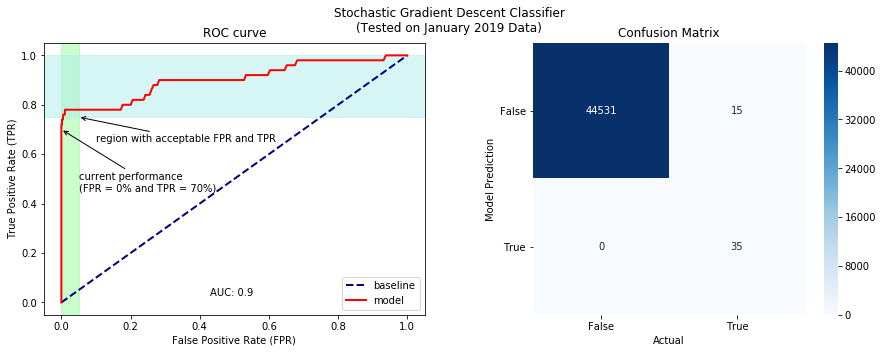

In [8]:
from utils import confusion_matrix_visual, plot_roc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_roc(y_jan, model.predict_proba(X_jan)[:,1], ax=axes[0])
axes[0].annotate(
    'current performance\n(FPR = 0% and TPR = 70%)', 
    xy=(0, 0.7), xytext=(0.05, 0.45), 
    arrowprops=dict(arrowstyle='->')
)
axes[0].axvspan(0, 0.05, color='palegreen', alpha=0.5)
axes[0].axhspan(0.75, 1, color='paleturquoise', alpha=0.5)
axes[0].annotate(
    'region with acceptable FPR and TPR', 
    xy=(0.05, 0.75), xytext=(0.1, 0.65), 
    arrowprops=dict(arrowstyle='->')
)

confusion_matrix_visual(
    y_jan, model.predict(X_jan), 
    class_labels=[False, True], ax=axes[1]
)

plt.suptitle(
    'Stochastic Gradient Descent Classifier\n'
    '(Tested on January 2019 Data)'
)

##### Try picking a custom threshold based on acceptable TPR and FPR

In [9]:
from utils import find_threshold

threshold = find_threshold(
    y_jan, model.predict_proba(X_jan)[:,1], 
    fpr_below=0.05, tpr_above=0.75
).max()
threshold

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.0013543411175580727

In [10]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_jan, model.predict_proba(X_jan)[:,1])
mask = thresholds == threshold
fpr_at_threshold, tpr_at_threshold = fpr[mask], tpr[mask]

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.5, 0.98, 'Stochastic Gradient Descent Classifier\n(Tested on January 2019 Data)')

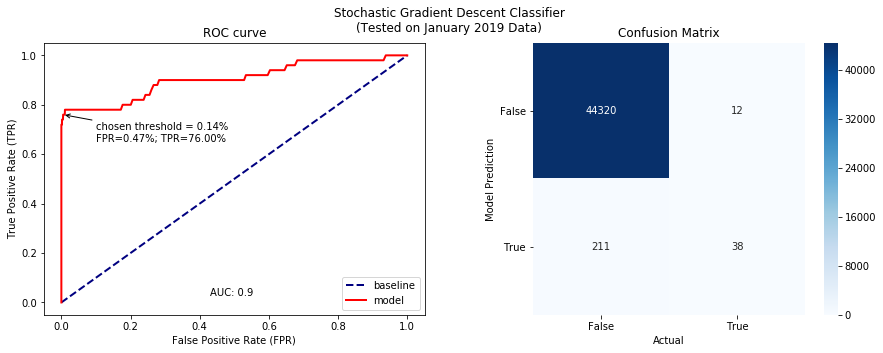

In [11]:
# not much improvement
from utils import confusion_matrix_visual, plot_roc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_roc(y_jan, model.predict_proba(X_jan)[:,1], ax=axes[0])
axes[0].annotate(
    f'chosen threshold = {threshold:.2%}\n'
    f'FPR={fpr_at_threshold[0]:.2%}; TPR={tpr_at_threshold[0]:.2%}', 
    xy=(fpr_at_threshold, tpr_at_threshold), xytext=(0.1, 0.65), 
    arrowprops=dict(arrowstyle='->')
)

confusion_matrix_visual(
    y_jan, model.predict_proba(X_jan)[:,1] >= threshold, 
    class_labels=[False, True], ax=axes[1]
)

plt.suptitle(
    'Stochastic Gradient Descent Classifier\n'
    '(Tested on January 2019 Data)'
)

#### Step 4: Update the model to include true labels for previously predicted test data (Jan 2019)

In [12]:
# update
model.partial_fit(X_jan, y_jan)

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PartialFitPipeline(memory=None,
          steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=1000, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

#### Step 5: Repeat process (this time we use Feb 2019)

In [13]:
X_feb, y_feb = get_X_y(logs_2019, '2019-02', hackers_2019)

In [14]:
print(classification_report(y_feb, model.predict(X_feb)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     40129
        True       1.00      0.67      0.80        12

   micro avg       1.00      1.00      1.00     40141
   macro avg       1.00      0.83      0.90     40141
weighted avg       1.00      1.00      1.00     40141



c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.5, 0.98, 'Stochastic Gradient Descent Classifier\n(Tested on February 2019 Data)')

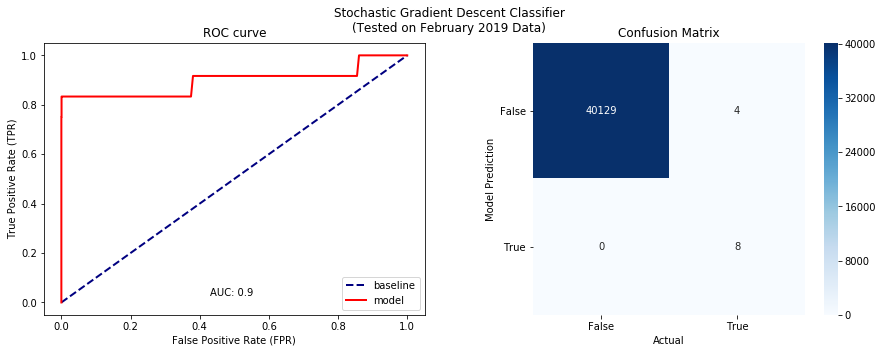

In [15]:
from utils import confusion_matrix_visual, plot_roc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_roc(y_feb, model.predict_proba(X_feb)[:,1], ax=axes[0])

confusion_matrix_visual(
    y_feb, model.predict(X_feb), 
    class_labels=[False, True], ax=axes[1]
)

plt.suptitle(
    'Stochastic Gradient Descent Classifier\n'
    '(Tested on February 2019 Data)'
)

## Putting our model to the test
In the time that we've been building all these models, March 2019 has come and gone. Our stakeholders are done waiting around for us and want results. Let's show our performance.

### Step 1: Update with the February 2019 data first

In [16]:
model.partial_fit(X_feb, y_feb)

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PartialFitPipeline(memory=None,
          steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=1000, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

### Step 2: Predict the March data for the stakeholders and send it off

In [17]:
X_march, y_march = get_X_y(logs_2019, '2019-03', hackers_2019)
march_2019_preds = model.predict(X_march)

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Step 3: Evaluation
The subject area experts examined our predictions and returned the following after checking our predictions.

In [18]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_march, march_2019_preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     44559
        True       1.00      0.82      0.90        11

   micro avg       1.00      1.00      1.00     44570
   macro avg       1.00      0.91      0.95     44570
weighted avg       1.00      1.00      1.00     44570



c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.5, 0.98, 'Stochastic Gradient Descent Classifier\n(Tested on March 2019 Data)')

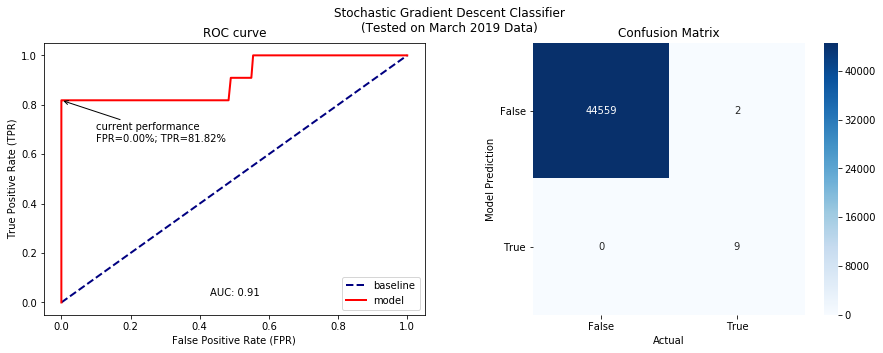

In [19]:
# ROC curve and confusion matrix
from utils import confusion_matrix_visual, plot_roc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_roc(y_march, model.predict_proba(X_march)[:,1], ax=axes[0])
confusion_matrix_visual(
    y_march, march_2019_preds, 
    class_labels=[False, True], ax=axes[1]
)
axes[0].annotate(
    f'current performance\nFPR={0:.2%}; TPR={9/11:.2%}', 
    xy=(0, 9/11), xytext=(0.1, 0.65), 
    arrowprops=dict(arrowstyle='->')
)

plt.suptitle(
    'Stochastic Gradient Descent Classifier\n'
    '(Tested on March 2019 Data)'
)